### TODO
- Manage NA values
- Manage useless features
    - `year` : merge with name
    - `link`, `logo` : delete
- Looking for strange values
    - score_i > score_j && rank_i > rank_j
- Using pandas categories
    - `country`, `city`, `region`
    - `type`, `size`, `research_ouptut`
- Looking for correlation between features
- Calculate rank for values with score but no rank (Temporarily dropped rows with no rank)


### Rapport du prof
- Tester différentes métriques
- Modèles à utiliser :
    - Linear model 
    - XGBoost ++
    - Decision tree
- Visualiser les données (matrice de corrélation)


### Notebook settings and imports

In [112]:
import numpy as np

import pandas as pd
from pandas.api.types import is_object_dtype, is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics


%matplotlib inline

In [113]:
data_init = pd.read_csv("qs-world-university-rankings-2017-to-2022-V2.csv")
N_init, D_init = data_init.shape
data_init.head()

,university,year,rank_display,score,link,country,city,region,logo,type,research_output,student_faculty_ratio,international_students,size,faculty_count
0,Massachusetts Institute of Technology (MIT),2017,1,100.0,https://www.topuniversities.com/universities/m...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,4.0,"3,730",M,"3,065"
1,Stanford University,2017,2,98.7,https://www.topuniversities.com/universities/s...,United States,Stanford,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,3.0,"3,879",L,"4,725"
2,Harvard University,2017,3,98.3,https://www.topuniversities.com/universities/h...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,5.0,"5,877",L,"4,646"
3,University of Cambridge,2017,4,97.2,https://www.topuniversities.com/universities/u...,United Kingdom,Cambridge,Europe,https://www.topuniversities.com/sites/default/...,Public,Very high,4.0,"7,925",L,"5,800"
4,California Institute of Technology (Caltech),2017,5,96.9,https://www.topuniversities.com/universities/c...,United States,Pasadena,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,2.0,692,S,968


In [114]:
data_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6482 entries, 0 to 6481
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   university              6482 non-null   object 
 1   year                    6482 non-null   int64  
 2   rank_display            6414 non-null   object 
 3   score                   2820 non-null   float64
 4   link                    6482 non-null   object 
 5   country                 6482 non-null   object 
 6   city                    6304 non-null   object 
 7   region                  6482 non-null   object 
 8   logo                    6482 non-null   object 
 9   type                    6470 non-null   object 
 10  research_output         6480 non-null   object 
 11  student_faculty_ratio   6407 non-null   float64
 12  international_students  6318 non-null   object 
 13  size                    6480 non-null   object 
 14  faculty_count           6404 non-null   

In [115]:
data_init.isna().sum()

university                   0
year                         0
rank_display                68
score                     3662
link                         0
country                      0
city                       178
region                       0
logo                         0
type                        12
research_output              2
student_faculty_ratio       75
international_students     164
size                         2
faculty_count               78
dtype: int64

### Clean-up : useless features

In [116]:
# Drop useless columns
useless_columns = [
    "link",
    "logo"
]
data = data_init.drop(columns=useless_columns, axis=1)

# Merge year with university's name
university_with_year = data["university"] + data["year"].map(" ({})".format)
data.insert(0, "university_with_year", university_with_year)
    # data = data.drop(columns=["university", "year"], axis=1)

In [117]:
# Replace N-M with N

rank_display_raw = data["rank_display"].map(lambda rank: str(rank).split("-")[0], na_action='ignore')
rank_display_raw = rank_display_raw.fillna(0)  # pour pouvoir convertir en entier
rank_display_raw = rank_display_raw.astype('int64')

data.insert(4, "rank_display_raw", rank_display_raw)
data["rank_display_raw"] = data['rank_display_raw'].replace(0, np.nan)

In [118]:
# Creating new feature for classification
data["class"] = [rank//100 for rank in data["rank_display_raw"]]

### Converting objects to categorical

In [119]:
# international_students and faculty_count are integers written as strings
for col in ["international_students", "faculty_count"]:
    if is_object_dtype(data[col]):
        data[col] = data[col].str.replace(',', '')
        data[col] = data[col].str.replace('.', '')
        data[col] = pd.to_numeric(data[col], errors='coerce')

C:\Users\Josse\AppData\Local\Temp\ipykernel_14640\25065419.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[col] = data[col].str.replace('.', '')


In [120]:
# In some columns different caps lead to different categories
# So before assigning categories everything is lowercased
for col in data.columns:
    if is_object_dtype(data[col]):
        data[col] = data[col].str.lower()
        data[col] = data[col].astype('category')
        data[col] = data[col].cat.codes + 1

### Clean-up : NA values

In [121]:
def fill_score_if_possible():
    """
    Check by year:
        - Group by ranks
        - Check for a value somewhere
        - Fill columns with the mean of the values found
    
    from 3662 to 3533 NA
    """

    years = data["year"].unique()
    
    for year in years:
        # Check by year
        data_year = data.loc[data["year"] == year]

        ranks = data_year["rank_display"].unique()
        for rank in ranks:
            # Group by ranks
            data_year_rank = data_year.loc[data["rank_display"] == rank]

            # If there's equalities, check for a missing value
            # If there is one, fill by the mean of the other values
            if data_year_rank.shape[0] > 1:
                data_year_rank_scores = data_year_rank["score"]
                if data_year_rank_scores.isna().sum() > 0:
                    data.loc[
                        (data["year"] == year) & (data["rank_display"] == rank),
                        "score"
                    ] = data_year_rank_scores.mean()
            
fill_score_if_possible()


In [122]:
# Filling some missing values with the median of the values from the same class
columns_to_fill = ["student_faculty_ratio", "international_students", "faculty_count"]
for col in columns_to_fill:
    data[col] = data[col].fillna(data.groupby('class')[col].transform('median'))

In [72]:
data.isna().sum().loc[data.isna().sum() > 0]

data_with_na = data.loc[data.isna().any(axis=1)]
data_count_na_by_row = data_with_na.isna().sum(axis=1)
data_count_na_by_row.sort_values(ascending=False)

max_na_count = 5
data_with_too_much_na_idxs = data_count_na_by_row.loc[data_count_na_by_row >= max_na_count].index

data.drop(data_with_too_much_na_idxs, inplace=True)

### Clean-up : Outliers values

In [73]:
# Removing rows with rank i > rank j but score i > score j
for year in range(2017, 2017+6):

    limit_rank = 400 if year <= 2018 else 500
    data_with_score = data.loc[data["rank_display_raw"]<=limit_rank]

    data.loc[data["rank_display_raw"]<=limit_rank, "old_index"] = data_with_score.index
    # data_with_score["old_index"] = data_with_score.index
    
    year_data = data_with_score.loc[data_with_score["year"]==year]
    sorted_score = year_data.sort_values(by=['score'], axis=0, ascending=False).reset_index()

    j=1
    while j < len(sorted_score):
        # Outlier
        if sorted_score.loc[j-1]["rank_display_raw"] > sorted_score.loc[j]["rank_display_raw"]:
            data.drop(index=sorted_score.loc[j]["old_index"], inplace=True)
            sorted_score.drop(index=j, inplace=True)
            sorted_score.reset_index(drop=True, inplace=True)
        else:
            j+=1


KeyboardInterrupt



In [ ]:
#Calculate data lost to cleaning
print("Data lost to cleaning :", (N_init - len(data))*100/N_init, "%")

Data lost to cleaning : 5.785251465597038 %


### Visualizing data



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6107 entries, 0 to 6481
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   university_with_year    6107 non-null   int16  
 1   university              6107 non-null   int16  
 2   year                    6107 non-null   int64  
 3   rank_display            6107 non-null   int16  
 4   rank_display_raw        6107 non-null   float64
 5   score                   2632 non-null   float64
 6   country                 6107 non-null   int8   
 7   city                    6107 non-null   int16  
 8   region                  6107 non-null   int8   
 9   type                    6107 non-null   int8   
 10  research_output         6107 non-null   int8   
 11  student_faculty_ratio   6107 non-null   float64
 12  international_students  6107 non-null   float64
 13  size                    6107 non-null   int8   
 14  faculty_count           6107 non-null   

<AxesSubplot:>

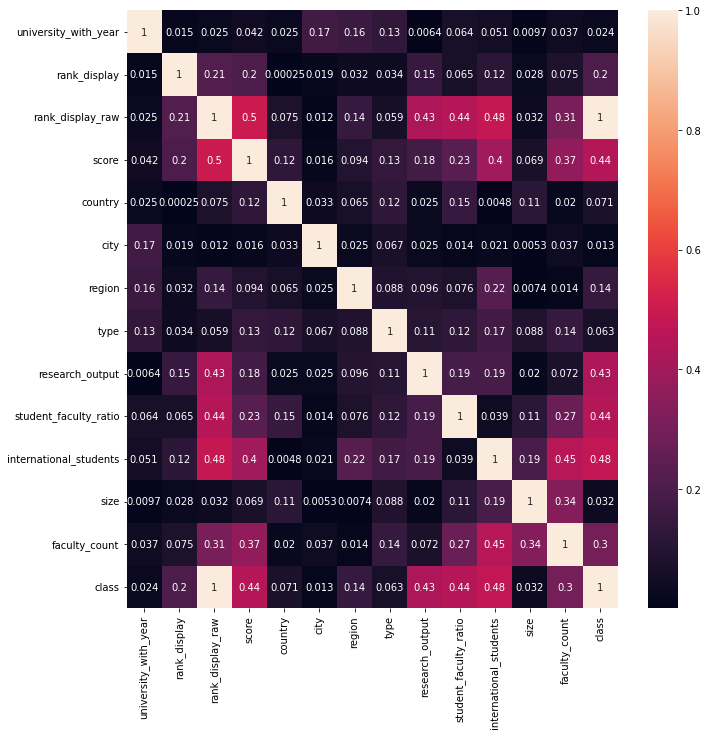

In [127]:
data_corr = data.drop(columns=["university", "year"], axis=1).corr()
plt.figure(figsize = (11,11))
sns.heatmap(abs(data_corr), annot = True)

### Decision Tree

In [128]:
data.dropna(subset=["class"], inplace=True)

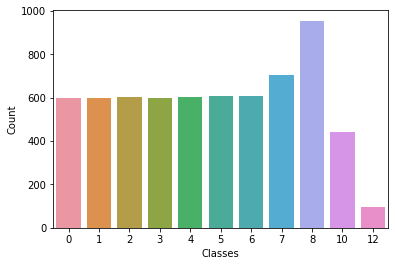

In [165]:
ax = sns.countplot(x="class", data=data)
plt.xlabel("Classes")
plt.ylabel("Count")
xticks = ax.get_xticklabels()

plt.xticks(
    range(len(xticks)),
    [t.get_text().split(".")[0] for t in xticks]
)
plt.show()


# plt.bar(data["class"].unique(), data["class"].value_counts())
# plt.xlabel("Classes")

In [207]:
def get_training_sets(data, target_label, test_size=0.2):
    return train_test_split(
        data.drop(labels=target_label, axis=1),
        data[target_label],
        test_size=test_size
    )


def score(clf, test_x, test_y):

    pred_y = predict(clf, test_x)

    d = {
        "accuracy": metrics.accuracy_score,
        "precision": lambda true, pred: metrics.precision_score(true, pred, average='micro'),
        "recall": lambda true, pred: metrics.recall_score(true, pred, average='micro'),
        "jaccard": lambda true, pred: metrics.jaccard_score(true, pred, average='micro'),
    }

    return {
        name: method(test_y, pred_y)
        for name, method in d.items()
    }


def predict(clf, x):
    return clf.predict(x)


def show_tree_results(clf, test_x, test_y, with_graph=True):
    # Scores
    scores = score(clf, test_x, test_y)
    print("Scores:")
    print(
        "\n".join([
            f"  {name.capitalize()}: {score:0.2f}"
            for name, score in scores.items()
        ])
    )

    # Features importance
    feature_importances = {
        name: importance
        for name, importance in zip(clf.feature_names_in_, clf.feature_importances_)
    }

    print("Features importance:")
    print("\n".join([
        f"  {name}: {importance:0.2f}"
        for name, importance in feature_importances.items()
    ]))

    # Graph
    if with_graph:
        plt.figure(figsize=(20, 20))
        tree.plot_tree(clf, fontsize=6)
        plt.savefig('tree_results', dpi=100)
        

def decision_tree():
    not_feature_cols = [
        "university_with_year", "university", "year",
        "rank_display", "rank_display_raw", "score"
    ]
    tree_data = data.drop(labels = not_feature_cols, axis = 1)
    train_x, test_x, train_y, test_y = get_training_sets(tree_data, "class")
    
    # Training
    tree_clf = tree.DecisionTreeClassifier()
    tree_clf.fit(train_x, train_y)
    
    # Results
    show_tree_results(tree_clf, test_x, test_y, with_graph=False)
    
decision_tree()

Scores:
  Accuracy: 0.60
  Precision: 0.60
  Recall: 0.60
  Jaccard: 0.43

Features importance:
  country: 0.12
  city: 0.16
  region: 0.04
  type: 0.02
  research_output: 0.04
  student_faculty_ratio: 0.17
  international_students: 0.25
  size: 0.03
  faculty_count: 0.17


### Regression